In [1]:
# Отдельная генерация и сохранение train/text массивов для xgbooster  (2017-07-02)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, estimateResult

In [6]:
binsData = 96

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trWork, teWork = '../Work/Train', '../Work/Test'
print (trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [7]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [9]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [10]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [11]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [12]:
#
# Построение по входным наборам гистограмм и переработанных изображений (изменение размеров, улучшение, сглаживание
#

def formX3 (ni, resize=(32,32), printOK=False, GaussianOK=True, EqualizeOK=False) :
        if GaussianOK : ni = np.array([cv.GaussianBlur(ni[:,:,i],(3,3),0) for i in range(ni.shape[2])]).T;
        if EqualizeOK : ni = np.array([cv.equalizeHist(ni[:,:,i]) for i in range(ni.shape[2])]).T;
        if resize and ((ni.shape[0],ni.shape[1])<>resize) : ni = cv.resize(ni,resize)
        return(ni)
    
def formX4 (ni, resize=(32,32), printOK=False, GaussianOK=True, EqualizeOK=False, OnlyNI=False, ExtIndex=True) :
    
        #before or after???? 
        #Equalize only 256 color!  ni = np.array([cv.equalizeHist(ni[:,:,i]) for i in range(ni.shape[2]-1)]).T;
        
        if GaussianOK : ni = np.array([cv.GaussianBlur(ni[:,:,i],(3,3),0) for i in range(ni.shape[2])]).T;
        r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,0],ni[:,:,3]
        if resize and ((ni.shape[0],ni.shape[1])<>resize) : 
            r,g,b,n = cv.resize(r,resize),cv.resize(g,resize),cv.resize(b,resize),cv.resize(n,resize)
        r,g,b,n = np.array(r,np.float32),np.array(g,np.float32),np.array(b,np.float32),np.array(n,np.float32)
        rn,gn,bn,nn = r-r.mean(), g-g.mean(), b-b.mean(), n-n.mean() # ??? на пробу
        
        # навал индексной массы
        ndvi,ndwi  = np.divide((rn-nn),(rn+nn+0.0001)), np.divide((gn-nn),(gn+nn+0.0001))
        ## ? unknown range evi        = 2.5*np.divide((n-r),(n+6*r-7.5*b+1.0))
        evi2       = 2.5*np.divide((nn-rn),(nn+2.4*rn+1.0))
        savi       = 1.5*np.divide((nn-rn),(nn+rn+1.0))
        
        # аккуратно переводим r,g,b,n из 0..65536 в 0..256 = uint8
        r,g,b,n = np.array(r/256.0,np.uint8), np.array(g/256.0,np.uint8), np.array(b/256.0,np.uint8), np.array(n/256.0,np.uint8)
        if (not OnlyNI) and EqualizeOK : r,g,b   = cv.equalizeHist(r), cv.equalizeHist(g),  cv.equalizeHist(b)

        # аккуратно переводим индекснуюю массу из [-1..1] в 0..256 = uint8
        ndvi,ndwi   = np.array((ndvi+1.0)/2.0*256.0,np.uint8), np.array((ndwi+1.0)/2.0*256.0,np.uint8)
        if ExtIndex :
            ## unknown range ? evi     = np.array((evi+1.0)/2.0*256.0,np.uint8)
            evi2    = np.array((evi2+1.041660)/3.541622*256.0,np.uint8)
            savi    = np.array((savi+1.499977)/3.0*256.0,np.uint8)
            ni      = np.array([r,g,b,n,ndvi,ndwi,evi2,savi]).T if not OnlyNI else np.array([n,ndvi,ndwi,evi2,savi]).T;
        else : ni   = np.array([r,g,b,n,ndvi,ndwi]).T if not OnlyNI else np.array([n,ndvi,ndwi]).T;

        #print('----',r[0,0],g[0,0],b[0,0],n[0,0],dv[0,0],dw[0,0],nx[0,0,5])
        del r,g,b,n,ndvi,ndwi,evi2,savi
        return (ni)

def formImExt (nf, resize=(32,32), printOK=False, OnlyNI=False, GaussianOK=True, EqualizeOK=False, ExtIndex=True) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
                
            if (ni.shape[2]==3) :   nx = formX3 (ni, resize=resize, GaussianOK=GaussianOK, EqualizeOK=EqualizeOK)
                
            if (ni.shape[2]==4) :   nx = formX4 (ni, resize=resize, GaussianOK=GaussianOK, EqualizeOK=EqualizeOK, OnlyNI=OnlyNI, ExtIndex=ExtIndex)

    except BaseException as e : 
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

def formImHist (nf, count, printOK=False, OnlyNI=False, GaussianOK=True, EqualizeOK=False, ExtIndex=True) :
    
    def histN (nf,bins) :
        h = []
        for i in range(nf.shape[2]) : 
            hh,_ = np.histogram(nf[:,:,i].ravel(),bins=bins)
            h = h + hh.tolist()
        return (np.array(h,dtype=np.uint16))
             
    def calculateBins (low,high,count) :
        size    = float(high-low)/float(count)
        bins = [low+x*size for x in range(count+1)]; #print(count,size,len(bins),bins[:3],bins[-3:])
        return (bins)
             
    nx = None
    try : 
        ni = formImExt (nf, resize=False, printOK=printOK, OnlyNI=OnlyNI, GaussianOK=GaussianOK, EqualizeOK=EqualizeOK, ExtIndex=ExtIndex)
        if (ni is not None) :
            
            if printOK : print('formExtHist 1.1:',nf,ni.shape, ni.min(), ni.max())
            bins = calculateBins(0,255,count)
            if printOK : print('formExtHist 1.2:',count,bins[:4],bins[-4:])
            nx = histN(ni,bins)
            if printOK : print('formExtHist 1.3:',nf,nx.shape)
            
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [13]:
def generateArrays( dirIn, nameAsk, binsData, debugOK=False) :
    #nameAsk = os.listdir(dirIn); print(len(nameAsk))
    trOX, trOY, i, size = [], [], 0, len(nameAsk)
    if debugOK : size = 10
    print(datetime.datetime.now(),len(nameAsk),size)
    for nn in nameAsk[0:size] :
        nf = os.path.join(dirIn,nn);
        nx = formImHist(nf, binsData, printOK=debugOK, ExtIndex=True)
        ##nx = formImHist(nf,binsData,printOK=debugOK,EqualizeOK=False,GaussianOK=True)
        if (i==0) : trOX = np.zeros((size,nx.shape[0]),dtype=np.uint16) ## расчет на максимальный массив 256x256=65536=np.uint16
        if (nx is not None) :
            trOX[i] = nx
            trOY.append(nn)
        i += 1
        if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
            
    ##trOX = np.array(trOX);
    trOY = np.array([os.path.splitext(x)[0] for x in trOY]);

    print(datetime.datetime.now())
    return (trOX, trOY)

def generateTest ( dirIn, binsData, debugOK=False) :
    nameAsk = os.listdir(dirIn); #print(len(nameAsk))
    return(generateArrays(dirIn,nameAsk,binsData,debugOK=debugOK))

def generateTrain( dirIn, binsData, nameList, debugOK=False) :
    ##nameAsk = os.listdir(dirIn); #print(len(nameAsk))
    return(generateArrays(dirIn,nameList,binsData,debugOK=debugOK))


In [14]:
param = {}
param['.jpg'] = (trDirJPG,teDirJPG)
param['.tif'] = (trDirTIF,teDirTIF)

In [15]:
binsList  = [32,64,128,256]
debug     = False
work_list = [(i,'.jpg') for i in binsList] + [(i,'.tif') for i in binsList]
#work_list, param, param[work_list[0][1]][1]

In [ ]:
trOY = labelList;
for bds, ttExt in work_list :
    dirIn = param[ttExt][0]
    print ('-------->: bins={} Ext={} input-dir={}'.format(bds,ttExt,dirIn))
    nameListExt = [x+ttExt for x in nameList]
    trOX, _     = generateTrain(dirIn,bds,nameListExt,debugOK=debug)
    fnameXX = '../Data-XGB/Datas/train-'+str(10000+bds)+ttExt+'-XX.npy'; 
    fnameYY = '../Data-XGB/Datas/train-'+str(10000+bds)+ttExt+'-YY.npy';
    np.save(fnameXX,trOX)
    np.save(fnameYY,trOY)
    print ('XX ({}-{}) -> {}'.format(bds,ttExt,fnameXX))
    print ('YY ({}-{}) -> {}'.format(bds,ttExt,fnameYY))
    #print (bds,trOX.shape,trOY.shape, (trOX.shape[1]/bds)*bds, trOX.shape[1]/3)dirIn    = teDirJPG

-------->: bins=32 Ext=.jpg input-dir=../Data/train-jpg
2017-07-14 04:16:54.307684 40479 40479
2017-07-14 04:19:25.677733 	 5000 	 train_4999.jpg
2017-07-14 04:21:52.626138 	 10000 	 train_9999.jpg
2017-07-14 04:23:54.043736 	 15000 	 train_14999.jpg
2017-07-14 04:25:40.811732 	 20000 	 train_19999.jpg
2017-07-14 04:27:10.373946 	 25000 	 train_24999.jpg
2017-07-14 04:28:29.820227 	 30000 	 train_29999.jpg
2017-07-14 04:29:45.317296 	 35000 	 train_34999.jpg
2017-07-14 04:31:01.783020 	 40000 	 train_39999.jpg
2017-07-14 04:31:08.656032
XX (32-.jpg) -> ../Data-XGB/Datas/train-10032.jpg-XX.npy
YY (32-.jpg) -> ../Data-XGB/Datas/train-10032.jpg-YY.npy
-------->: bins=64 Ext=.jpg input-dir=../Data/train-jpg
2017-07-14 04:31:08.723473 40479 40479
2017-07-14 04:31:44.744280 	 5000 	 train_4999.jpg
2017-07-14 04:32:21.045302 	 10000 	 train_9999.jpg
2017-07-14 04:32:56.880294 	 15000 	 train_14999.jpg
2017-07-14 04:33:32.840703 	 20000 	 train_19999.jpg
2017-07-14 04:34:08.969464 	 25000 	 tr

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide


2017-07-14 04:51:03.816482 	 5000 	 train_4999.tif
2017-07-14 04:55:50.861837 	 10000 	 train_9999.tif
2017-07-14 05:00:28.610131 	 15000 	 train_14999.tif
2017-07-14 05:05:06.106441 	 20000 	 train_19999.tif
2017-07-14 05:09:33.642855 	 25000 	 train_24999.tif
2017-07-14 05:14:06.484157 	 30000 	 train_29999.tif
2017-07-14 05:18:26.616294 	 35000 	 train_34999.tif
2017-07-14 05:22:48.692247 	 40000 	 train_39999.tif
2017-07-14 05:23:12.234900
XX (32-.tif) -> ../Data-XGB/Datas/train-10032.tif-XX.npy
YY (32-.tif) -> ../Data-XGB/Datas/train-10032.tif-YY.npy
-------->: bins=64 Ext=.tif input-dir=../Data/train-tif-v2
2017-07-14 05:23:12.356978 40479 40479
2017-07-14 05:27:18.486716 	 5000 	 train_4999.tif
2017-07-14 05:31:20.645932 	 10000 	 train_9999.tif
2017-07-14 05:35:24.286079 	 15000 	 train_14999.tif
2017-07-14 05:39:25.720438 	 20000 	 train_19999.tif
2017-07-14 05:43:25.739557 	 25000 	 train_24999.tif
2017-07-14 05:47:28.999594 	 30000 	 train_29999.tif
2017-07-14 05:51:29.35782

65535 0 255.969959732


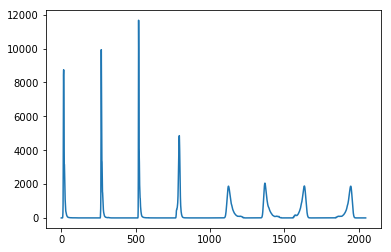

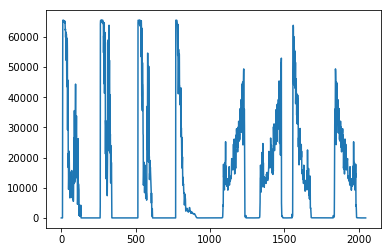

In [42]:
print (trOX.max(), trOX.min(), trOX.mean())
#print (trOX.max(axis=0), trOX.min(axis=0), trOX[:].mean(axis=0))

trOX.shape, 512/64
plt.plot(trOX.mean(axis=0)); plt.show()
plt.plot(trOX.max(axis=0)); plt.show()
#plt.plot(trOX[0:10000].min(axis=0)); plt.show()

In [16]:
for bds, ttExt in work_list :
    dirIn = param[ttExt][1]
    print ('-------->: bins={} Ext={} input-dir={}'.format(bds,ttExt,dirIn))
    trOX, trOY = generateTest(dirIn,bds,debugOK=debug)
    fnameXX = '../Data-XGB/Datas/test-'+str(10000+bds)+ttExt+'-XX.npy'; 
    fnameYY = '../Data-XGB/Datas/test-'+str(10000+bds)+ttExt+'-YY.npy'; 
    np.save(fnameXX,trOX)
    np.save(fnameYY,trOY)
    print ('OX ({}-{}) -> {}'.format(bds,ttExt,fnameXX))
    print ('OY ({}-{}) -> {}'.format(bds,ttExt,fnameYY))

-------->: bins=32 Ext=.jpg input-dir=../Data/test-jpg-v2
2017-07-14 08:28:34.480080 61191 61191
2017-07-14 08:29:12.198564 	 5000 	 test_14523.jpg
2017-07-14 08:29:49.391236 	 10000 	 test_19029.jpg
2017-07-14 08:30:28.159189 	 15000 	 test_23524.jpg
2017-07-14 08:31:05.324068 	 20000 	 test_28015.jpg
2017-07-14 08:31:41.610784 	 25000 	 test_32520.jpg
2017-07-14 08:32:17.669860 	 30000 	 test_37026.jpg
2017-07-14 08:32:54.043556 	 35000 	 test_4908.jpg
2017-07-14 08:33:30.282428 	 40000 	 test_9402.jpg
2017-07-14 08:34:06.796065 	 45000 	 file_13913.jpg
2017-07-14 08:34:42.870197 	 50000 	 file_18419.jpg
2017-07-14 08:35:30.712823 	 55000 	 file_4564.jpg
2017-07-14 08:36:12.631943 	 60000 	 file_892.jpg
2017-07-14 08:36:22.015549
OX (32-.jpg) -> ../Data-XGB/Datas/test-10032.jpg-XX.npy
OY (32-.jpg) -> ../Data-XGB/Datas/test-10032.jpg-YY.npy
-------->: bins=64 Ext=.jpg input-dir=../Data/test-jpg-v2
2017-07-14 08:36:23.187403 61191 61191
2017-07-14 08:37:00.482502 	 5000 	 test_14523.jp

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide


2017-07-14 09:04:32.040752 	 5000 	 test_15645.tif
2017-07-14 09:10:14.985079 	 10000 	 test_2615.tif
2017-07-14 09:16:05.902675 	 15000 	 test_6054.tif
2017-07-14 09:21:32.605521 	 20000 	 test_22406.tif
2017-07-14 09:26:57.799346 	 25000 	 test_37025.tif
2017-07-14 09:32:00.625405 	 30000 	 test_8910.tif
2017-07-14 09:37:17.822750 	 35000 	 test_39596.tif
2017-07-14 09:42:20.059738 	 40000 	 test_7740.tif
2017-07-14 09:47:38.504782 	 45000 	 test_35456.tif
2017-07-14 09:52:36.506684 	 50000 	 file_17548.tif
2017-07-14 09:57:52.281218 	 55000 	 test_19494.tif
2017-07-14 10:02:42.672598 	 60000 	 test_2939.tif
2017-07-14 10:04:00.209853
OX (32-.tif) -> ../Data-XGB/Datas/test-10032.tif-XX.npy
OY (32-.tif) -> ../Data-XGB/Datas/test-10032.tif-YY.npy
-------->: bins=64 Ext=.tif input-dir=../Data/test-tif-v2
2017-07-14 10:04:01.415375 61191 61191
2017-07-14 10:08:38.509657 	 5000 	 test_15645.tif
2017-07-14 10:13:01.075404 	 10000 	 test_2615.tif
2017-07-14 10:17:28.322015 	 15000 	 test_60

In [ ]:
print (trOX.max(), trOX.min(), trOX.mean())
#print (trOX.max(axis=1), trOX.min(), trOX[:].mean())

trOX.shape, 512/64
plt.plot(trOX[0:10000].mean(axis=0)); plt.show()
plt.plot(trOX[0:10000].max(axis=0)); plt.show()
#plt.plot(trOX[0:10000].min(axis=0)); plt.show()

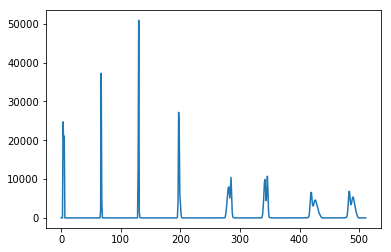

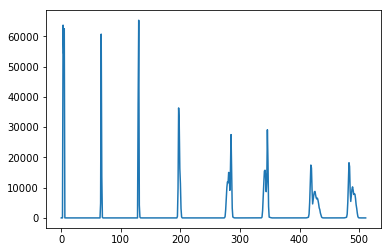

In [32]:
plt.plot(trOX[0:10000].mean(axis=0)); plt.show()
plt.plot(trOX[0:10000].max(axis=0)); plt.show()

In [25]:
ax  = trOX
ax2 = np.zeros((ax.shape[0],(ax.shape[1]/2)))
for i in range(ax2.shape[1]) :
    ax2[:,i] = ax[:,2*i]+ax[:,2*i+1]
trOX.shape, ax2.shape

((61191, 384), (61191, 192))

In [153]:
##--------------------- Examples save/load procedure

In [154]:
if False :
    trX = np.load('../Work/train-data-XX'+str(binsData)+ttExt+'.npy')
    trY = np.load('../Work/train-data-YY'+str(binsData)+ttExt+'.npy')
    print(trX.shape,trY.shape)

In [155]:
if False :
    np.save('../Work/test-data-XX'+str(binsData)+ttExt+'.npy',trOX)
    np.save('../Work/test-data-YY'+str(binsData)+ttExt+'.npy',trOY)